# Improved LSTM baseline

This kernel is a somewhat improved version of [Keras - Bidirectional LSTM baseline](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051) along with some additional documentation of the steps. (NB: this notebook has been re-run on the new test set.)

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Incluímos os vetores de palavras GloVe em nossos arquivos de entrada. Para incluí-los no kernel, clique em 'arquivos de entrada' na parte superior do notebook e pesquise 'glove' na seção 'conjuntos de dados'.

In [ ]:
path = ''
comp = 'toxic/'
EMBEDDING_FILE=f'{path}{comp}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}{comp}train.csv'
TEST_DATA_FILE=f'{path}{comp}test.csv'

alguns parâmetros básicos de configuração:

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

Leia nossos dados e substitua os valores ausentes:

In [ ]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Pré-processamento de keras padrão, para transformar cada comentário em uma lista de índices de palavras de igual comprimento (com truncamento ou preenchimento, conforme necessário).

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Leia os vetores de palavras dos modelos glove (cadeias delimitadas por espaço) em um dicionário a partir de word-> vector.

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use esses vetores para criar nossa matriz de incorporação, com inicialização aleatória para palavras que não estão no GloVe. Usaremos a mesma média e padrão de incorporação que o GloVe possui ao gerar o init aleatório.

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.020940498, 0.6441043)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

STM bidirecional simples com duas camadas totalmente conectadas. Adicionamos algum abandono ao LSTM, já que até duas épocas são suficientes para superestimar.

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [ ]:
history = model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1506s 10ms/step - loss: 0.0683 - accuracy: 0.9767 - val_loss: 0.0567 - val_accuracy: 0.9801
Epoch 2/2
143613/143613 [==============================] - 1483s 10ms/step - loss: 0.0545 - accuracy: 0.9806 - val_loss: 0.0525 - val_accuracy: 0.9812


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


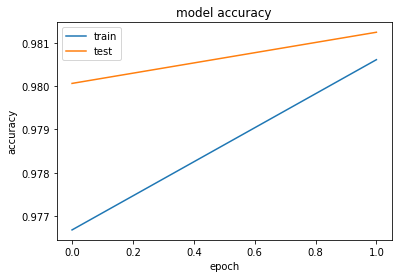

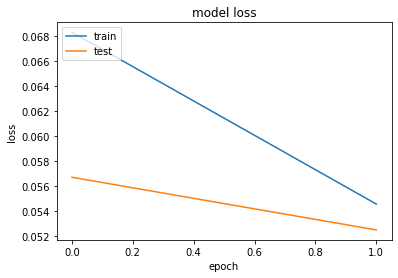

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

E, finalmente, obtenha previsões para o conjunto de testes e prepare um CSV de envio:

In [ ]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'{path}{comp}sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 5s 31us/step


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'{path}{comp}sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 5s 30us/step
